강의 및 코드 출처 : https://www.youtube.com/watch?v=rdR2fNDq6v0

# 시계열 데이터 분석 : ARIMA Model

In [1]:
#pip install pandas_datareader

## 1. 모듈 불러오기

In [2]:
import os

import pandas as pd
import pandas_datareader.data as pdr

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

import matplotlib.pyplot as plt
import matplotlib
plt.style.use('seaborn-whitegrid')

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.arima import auto_arima

import seaborn as sns

plt.style.use('seaborn-whitegrid')
#sns.set_style('white')
%matplotlib inline

import itertools

## 2. 데이터 불러오기

활용데이터는 공공데이터로 1949~1960년 매달 비행기 탑승객에 대한 시계열 데이터

In [3]:
data = pd.read_csv('C:\\Users\\HP\\Downloads\\AirPassengers.csv')
data = data.rename(columns={'Month': 'month', '#Passengers': 'passengers'})
data['month'] = pd.to_datetime(data['month'])
data = data.set_index('month')
data

,passengers
month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121
...,...
1960-08-01,606
1960-09-01,508
1960-10-01,461


## 3. Box-Jenkins ARIMA Procedure
#### 3.1 Data Preprocessing
#### 3.2 Identify Model to be Tentatively Entertained
#### 3.3 Estimate Parameters
#### 3.4 Diagnosis Check
#### 3.5 use Model to Forecast

### 3.1 Data Preprocessing

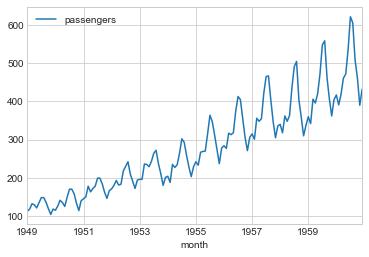

In [4]:
# Raw data plot
fig = data.plot()

시간이 지날 수록 증가하며 패턴이 보인다.

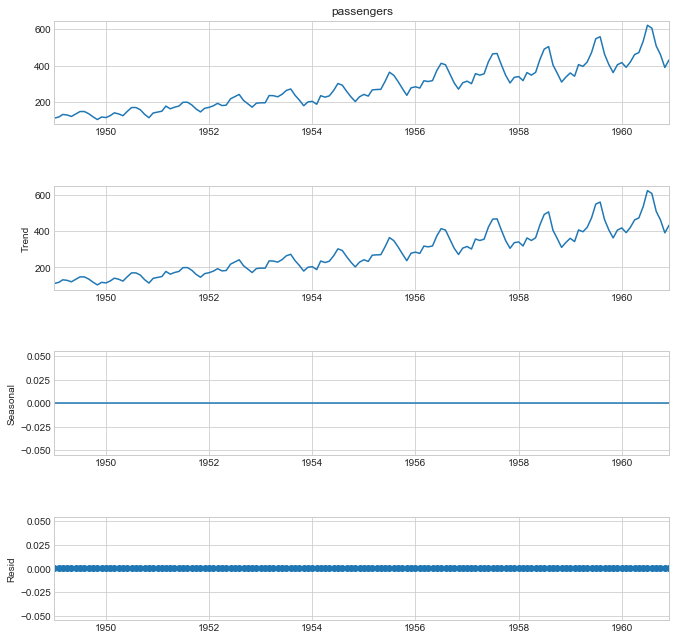

In [5]:
# Sesonal decomposition lot : Seasonal decomposition using moving averages.
# https://www.statsmodels.org/stable/generated/statsmodels.tsa.seasonal.seasonal_decompose.html

# Obsrerved : observed data
# Trend : The estimated trend component
# Seasonal : The eastimate seasonal component
# resid : The estimated residuals

decomposition = sm.tsa.seasonal_decompose(data['passengers'], model='additive', period=1)
fig = decomposition.plot()
fig.set_size_inches(10,10)
plt.show()

### 3.2 Identify Model to be Tentatively Entertained

In [6]:
# Train : Test = 8 : 2
train_data, test_data = train_test_split(data, test_size=0.2, shuffle=False)

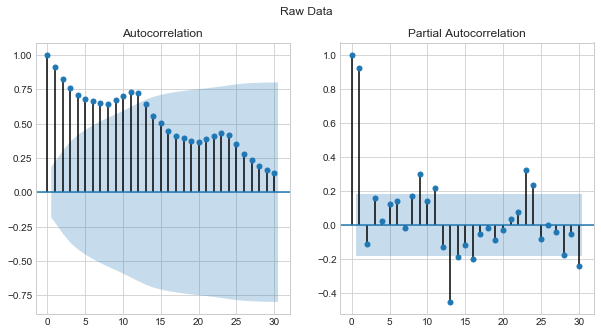

In [7]:
# ACF, PACF plot

# http://www.statsmodels.org/stable/generated/statsmodels.graphics.tsaplots.plot_acf.html
# http://www.statsmodels.org/stable/generated/statsmodels.graphics.tsaplots.plot_pacf.html

fig, ax = plt.subplots(1, 2, figsize=(10,5))
fig.suptitle('Raw Data')
sm.graphics.tsa.plot_acf(train_data.values.squeeze(), lags=30, ax=ax[0])
sm.graphics.tsa.plot_pacf(train_data.values.squeeze(), lags=30, ax=ax[1]); # Modify not to generate graph twice

데이터가 nonstationary인지는 ACF을 보고 판단합니다. ACF이 천천히 감소하는 패턴을 보이고 있으면 nonstationary time series data라고 보시면 됩니다. ACF 보면 파도모양인데 대표적인 Non Stationary data의 패턴이다.

Non Stationary 한 데이터를 Stationary 하게 바꿔줘야 하는데 우리가 활용한 방법은 차분이다.

## 차분 (Differnecing)

If original series is nonstationary, diffrencing might be needed

차분 : 현 시점 데이터에서 d시점 이전 데이터를 뺀것 (1차 차분, 2차 차분, ... d차 차분)

In [8]:
# Diffrencing

diff_train_data = train_data.copy()
diff_train_data = diff_train_data['passengers'].diff() # 1차 차분이라 값이 필요 없다.
diff_train_data = diff_train_data.dropna() # 결측치 제거
print('###### Raw Data ######')
print(train_data)
print('### Differenced Data ###')
print(diff_train_data)

###### Raw Data ######
            passengers
month                 
1949-01-01         112
1949-02-01         118
1949-03-01         132
1949-04-01         129
1949-05-01         121
...                ...
1958-03-01         362
1958-04-01         348
1958-05-01         363
1958-06-01         435
1958-07-01         491

[115 rows x 1 columns]
### Differenced Data ###
month
1949-02-01     6.0
1949-03-01    14.0
1949-04-01    -3.0
1949-05-01    -8.0
1949-06-01    14.0
              ... 
1958-03-01    44.0
1958-04-01   -14.0
1958-05-01    15.0
1958-06-01    72.0
1958-07-01    56.0
Name: passengers, Length: 114, dtype: float64


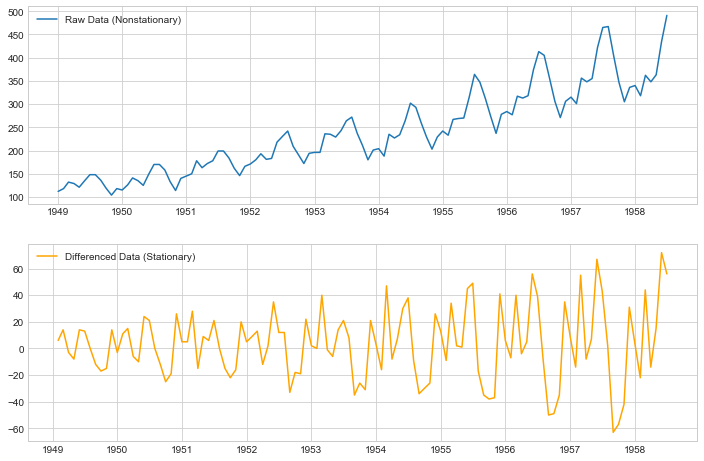

In [9]:
# Differenced data plot

plt.figure(figsize=(12,8))
plt.subplot(211)
plt.plot(train_data['passengers'])
plt.legend(['Raw Data (Nonstationary)'])
plt.subplot(212)
plt.plot(diff_train_data, 'orange') # first difference (t - (t-1))
plt.legend(['Differenced Data (Stationary)'])
plt.show()

위에가 실제 데이터 아래가 차분 후 데이터 인데, 차분 후에 Stationary 하게 된 것을 확인 할 수 있다.

C:\Users\HP\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1406: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


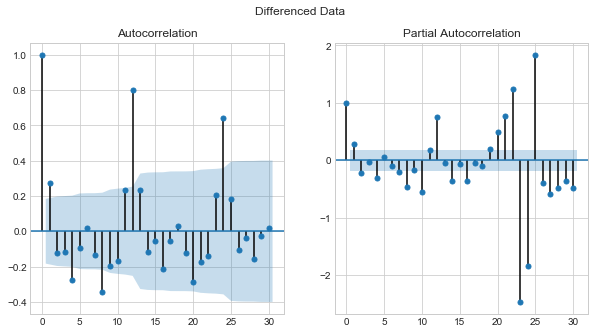

In [10]:
# ACF, PACF (1차 차분화 된 데이터 활용)

fig, ax = plt.subplots(1, 2, figsize=(10,5))
fig.suptitle('Differenced Data')
sm.graphics.tsa.plot_acf(diff_train_data.values.squeeze(), lags=30, ax=ax[0])
sm.graphics.tsa.plot_pacf(diff_train_data.values.squeeze(), lags=30, ax=ax[1]); # Modify not to generate graph twice

살펴 보면 이제 사인 함같은 것이 되었고 서서히 높이가 감소 되는 것을 알 수 있다.

## 이 시점에서 graphic한 것을 보고 모델링을 어떤 방향으로 할지 판단 해야 한다.
## Identification ARIMA Model

* Graphical method making inferences from the patterns of the sample autocorrelation and partial autocorrelation functions of the series

Model             /                    ACF                /            Partial ACF
* MA(q) : Cut off after lag q (q시차 이후 0으로 절단), Die out(지수적으로 감소, 소멸하는 sine함수 형태)
* AR(p) : Die out(지수적으로 감소, 소멸하는 sine함수 형태), Cut off after lag p (p시차 이후 0으로 절단)
* ARMA(p,q) : Die out(시차 (q-p)이후 부터 소멸, Die out(시차 (q-p)이후 부터 소멸

##### 지금 위의 그래프를 보면 ACF가 sine함수를 띄고 지수적으로 소멸하는 것처럼 보인다. 따라서 AR모델을 선택한다.

##### 그 뒤에 p를 선정해야 하는데 PACF 딱 감소하는 그런 부분을 찾기가 어려워서 일단은 1로 선정을 함 (차분이 1인 모델을 구성하겠다.)

### 3.3 Estimate Parameters

In [11]:
# ARIMA model fitting
# The (p,d,q) after of the model for the number of AR parameters, differences and MA parameters to use

model = ARIMA(train_data.values, order=(1,1,0)) # p값과, 차분은 1
model_fit = model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                  114
Model:                 ARIMA(1, 1, 0)   Log Likelihood                -531.720
Method:                       css-mle   S.D. of innovations             25.659
Date:                Thu, 21 Oct 2021   AIC                           1069.440
Time:                        21:00:42   BIC                           1077.649
Sample:                             1   HQIC                          1072.771
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.5124      3.329      1.055      0.291      -3.012      10.037
ar.L1.D.y      0.2803      0.091      3.077      0.002       0.102       0.459
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            3.5681           +0.0000j            3.5681            0.0000
-----------------------------------------------------------------------------
"""

AIC 스코어가 1069인 것을 확인 할 수 있다.

### 3.4 1 Diagonisis Check - ARIMA

In [12]:
# Parameter search
# 파라미터 내에서 서칭을 하면서 가장 좋은 파라미터를 찾는다.

print('Examples of parameter combinations for Seasonnal ARIMA...')
p = range(0,3)
d = range(0,3)
q = range(0,3)
pdq = list(itertools.product(p, d, q))

aic = []
for i in pdq:
    model = ARIMA(train_data.values, order=(i))
    model_fit = model.fit()
    print(f'ARIMA:  {i} >> AIC : {round(model_fit.aic,2)}')
    aic.append(round(model_fit.aic,2))

Examples of parameter combinations for Seasonnal ARIMA...
ARIMA:  (0, 0, 0) >> AIC : 1367.73
ARIMA:  (0, 0, 1) >> AIC : 1232.92
ARIMA:  (0, 0, 2) >> AIC : 1168.94
ARIMA:  (0, 1, 0) >> AIC : 1076.52
ARIMA:  (0, 1, 1) >> AIC : 1064.62
ARIMA:  (0, 1, 2) >> AIC : 1061.08
ARIMA:  (0, 2, 0) >> AIC : 1107.69
ARIMA:  (0, 2, 1) >> AIC : 1074.28
ARIMA:  (0, 2, 2) >> AIC : 1061.98
ARIMA:  (1, 0, 0) >> AIC : 1092.21
ARIMA:  (1, 0, 1) >> AIC : 1078.07
ARIMA:  (1, 0, 2) >> AIC : 1076.3
ARIMA:  (1, 1, 0) >> AIC : 1069.44
ARIMA:  (1, 1, 1) >> AIC : 1058.83
ARIMA:  (1, 1, 2) >> AIC : 1046.05
ARIMA:  (1, 2, 0) >> AIC : 1103.06
ARIMA:  (1, 2, 1) >> AIC : 1066.77
ARIMA:  (1, 2, 2) >> AIC : 1056.43
ARIMA:  (2, 0, 0) >> AIC : 1083.13
ARIMA:  (2, 0, 1) >> AIC : 1073.72
ARIMA:  (2, 0, 2) >> AIC : 1073.77
ARIMA:  (2, 1, 0) >> AIC : 1066.2
ARIMA:  (2, 1, 1) >> AIC : 1045.66
ARIMA:  (2, 1, 2) >> AIC : 1047.19
ARIMA:  (2, 2, 0) >> AIC : 1091.63
ARIMA:  (2, 2, 1) >> AIC : 1063.96
ARIMA:  (2, 2, 2) >> AIC : 1057.75

In [13]:
# Search optimal parameters

optimal = [(pdq[i], j) for i, j in enumerate(aic) if j == min(aic)]
optimal

[((2, 1, 1), 1045.66)]

ARIMA (2,1,1)이 AIC 점수 1045로 제일 좋다

In [14]:
# 최적 모델 서머리 확인
model_opt = ARIMA(train_data.values, order=optimal[0][0])
model_opt_fit = model_opt.fit()

model_opt_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                  114
Model:                 ARIMA(2, 1, 1)   Log Likelihood                -517.830
Method:                       css-mle   S.D. of innovations             22.316
Date:                Thu, 21 Oct 2021   AIC                           1045.660
Time:                        21:00:44   BIC                           1059.341
Sample:                             1   HQIC                          1051.212
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.5600      0.162     15.754      0.000       2.241       2.878
ar.L1.D.y      1.0890      0.085     12.816      0.000       0.922       1.256
ar.L2.D.y     -0.4730      0.086     -5.528      0.000      -0.641      -0.305
ma.L1.D.y     -1.0000      0.040    -25.219      0.000      -1.078      -0.922
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.1512           -0.8882j            1.4540           -0.1046
AR.2            1.1512           +0.8882j            1.4540            0.1046
MA.1            1.0000           +0.0000j            1.0000            0.0000
-----------------------------------------------------------------------------
"""

### 3.5 1 use Model to Forecast- ARIMA

In [15]:
prediction = model_opt_fit.forecast(len(test_data))
predicted_value = prediction[0]
predicted_ub = prediction[2][:,0]
predicted_lb = prediction[2][:,1]
predict_index = list(test_data.index)
r2 = r2_score(test_data, predicted_value)

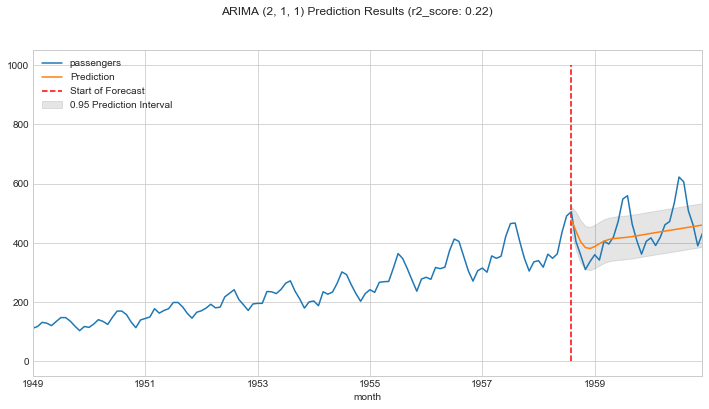

In [16]:
fig, ax = plt.subplots(figsize=(12,6))
data.plot(ax=ax);
ax.vlines('1958-08-01', 0, 1000, linestyle='--', color='r', label='Start of Forecast')
ax.plot(predict_index, predicted_value, label='Prediction')
ax.fill_between(predict_index, predicted_lb, predicted_ub, color='k', alpha=0.1, label='0.95 Prediction Interval')
ax.legend(loc='upper left')
plt.suptitle(f'ARIMA {optimal[0][0]} Prediction Results (r2_score: {round(r2,2)})')
plt.show()

파란색 선은 실제값, 주황색 선은 예측값, 회색은 인터벌 값이다.

트렌드가 있었으니까 이제 시즈널리티까지 반영한 사리마 모델을 만들어 보자

### 3.4 2 Diagonisis Check - SARIMA

In [17]:
# Parameter search


print('Examples of parameter combinations for Seasonnal ARIMA...')
p = range(0,3)
d = range(1,2)
q = range(0,3)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p,d,q))] 
# 여기서 어느정도 시즈널 값을 줄가인데 달마다 시즈널 값을 주려고 12를 입력함. 이건 변경 가능하다

aic = []
params=[]
for i in pdq:
    for j in seasonal_pdq:
        try:
            model = SARIMAX(train_data.values, order=(i), seasonal_order = (j))
            model_fit = model.fit()
            print(f'SARIMA:  {i}{j} >> AIC : {round(model_fit.aic,2)}')
            aic.append(round(model_fit.aic,2))
            params.append((i,j))
        except:
            continue
# 연산이 안되는 파라미터 값이 있어서 예외 처리를 작성함

Examples of parameter combinations for Seasonnal ARIMA...
SARIMA:  (0, 1, 0)(0, 1, 0, 12) >> AIC : 757.83
SARIMA:  (0, 1, 0)(0, 1, 1, 12) >> AIC : 756.99
SARIMA:  (0, 1, 0)(0, 1, 2, 12) >> AIC : 758.83
SARIMA:  (0, 1, 0)(1, 1, 0, 12) >> AIC : 756.96
SARIMA:  (0, 1, 0)(1, 1, 1, 12) >> AIC : 758.92
SARIMA:  (0, 1, 0)(1, 1, 2, 12) >> AIC : 754.42
SARIMA:  (0, 1, 0)(2, 1, 0, 12) >> AIC : 758.87
SARIMA:  (0, 1, 0)(2, 1, 1, 12) >> AIC : 760.73


C:\Users\HP\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


SARIMA:  (0, 1, 0)(2, 1, 2, 12) >> AIC : 754.91
SARIMA:  (0, 1, 1)(0, 1, 0, 12) >> AIC : 756.01
SARIMA:  (0, 1, 1)(0, 1, 1, 12) >> AIC : 756.38
SARIMA:  (0, 1, 1)(0, 1, 2, 12) >> AIC : 757.65
SARIMA:  (0, 1, 1)(1, 1, 0, 12) >> AIC : 756.17
SARIMA:  (0, 1, 1)(1, 1, 1, 12) >> AIC : 758.11


C:\Users\HP\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


SARIMA:  (0, 1, 1)(1, 1, 2, 12) >> AIC : 751.73
SARIMA:  (0, 1, 1)(2, 1, 0, 12) >> AIC : 757.99
SARIMA:  (0, 1, 1)(2, 1, 1, 12) >> AIC : 753.78
SARIMA:  (0, 1, 2)(0, 1, 0, 12) >> AIC : 757.78
SARIMA:  (0, 1, 2)(0, 1, 1, 12) >> AIC : 758.04
SARIMA:  (0, 1, 2)(0, 1, 2, 12) >> AIC : 759.28
SARIMA:  (0, 1, 2)(1, 1, 0, 12) >> AIC : 757.81
SARIMA:  (0, 1, 2)(1, 1, 1, 12) >> AIC : 759.75
SARIMA:  (0, 1, 2)(1, 1, 2, 12) >> AIC : 753.5
SARIMA:  (0, 1, 2)(2, 1, 0, 12) >> AIC : 759.64


C:\Users\HP\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


SARIMA:  (0, 1, 2)(2, 1, 1, 12) >> AIC : 755.48
SARIMA:  (0, 1, 2)(2, 1, 2, 12) >> AIC : 764.2
SARIMA:  (1, 1, 0)(0, 1, 0, 12) >> AIC : 755.5
SARIMA:  (1, 1, 0)(0, 1, 1, 12) >> AIC : 755.98
SARIMA:  (1, 1, 0)(0, 1, 2, 12) >> AIC : 757.1
SARIMA:  (1, 1, 0)(1, 1, 0, 12) >> AIC : 755.75
SARIMA:  (1, 1, 0)(1, 1, 1, 12) >> AIC : 757.65
SARIMA:  (1, 1, 0)(1, 1, 2, 12) >> AIC : 751.15
SARIMA:  (1, 1, 0)(2, 1, 0, 12) >> AIC : 757.45
SARIMA:  (1, 1, 0)(2, 1, 1, 12) >> AIC : 752.99
SARIMA:  (1, 1, 1)(0, 1, 0, 12) >> AIC : 756.02
SARIMA:  (1, 1, 1)(0, 1, 1, 12) >> AIC : 756.63
SARIMA:  (1, 1, 1)(0, 1, 2, 12) >> AIC : 757.75
SARIMA:  (1, 1, 1)(1, 1, 0, 12) >> AIC : 756.41
SARIMA:  (1, 1, 1)(1, 1, 1, 12) >> AIC : 758.26


C:\Users\HP\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


SARIMA:  (1, 1, 1)(1, 1, 2, 12) >> AIC : 752.53
SARIMA:  (1, 1, 1)(2, 1, 0, 12) >> AIC : 758.03
SARIMA:  (1, 1, 1)(2, 1, 1, 12) >> AIC : 754.16
SARIMA:  (1, 1, 1)(2, 1, 2, 12) >> AIC : 760.18
SARIMA:  (1, 1, 2)(0, 1, 0, 12) >> AIC : 757.92
SARIMA:  (1, 1, 2)(0, 1, 1, 12) >> AIC : 758.44
SARIMA:  (1, 1, 2)(0, 1, 2, 12) >> AIC : 759.63
SARIMA:  (1, 1, 2)(1, 1, 0, 12) >> AIC : 758.22
SARIMA:  (1, 1, 2)(1, 1, 1, 12) >> AIC : 760.1
SARIMA:  (1, 1, 2)(1, 1, 2, 12) >> AIC : 754.53
SARIMA:  (1, 1, 2)(2, 1, 0, 12) >> AIC : 759.92


C:\Users\HP\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


SARIMA:  (1, 1, 2)(2, 1, 1, 12) >> AIC : 756.17


C:\Users\HP\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


SARIMA:  (1, 1, 2)(2, 1, 2, 12) >> AIC : 763.6
SARIMA:  (2, 1, 0)(0, 1, 0, 12) >> AIC : 756.77
SARIMA:  (2, 1, 0)(0, 1, 1, 12) >> AIC : 757.23
SARIMA:  (2, 1, 0)(0, 1, 2, 12) >> AIC : 758.31
SARIMA:  (2, 1, 0)(1, 1, 0, 12) >> AIC : 756.98
SARIMA:  (2, 1, 0)(1, 1, 1, 12) >> AIC : 758.86
SARIMA:  (2, 1, 0)(1, 1, 2, 12) >> AIC : 752.77
SARIMA:  (2, 1, 0)(2, 1, 0, 12) >> AIC : 758.65


C:\Users\HP\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\HP\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\HP\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


SARIMA:  (2, 1, 0)(2, 1, 2, 12) >> AIC : 762.24
SARIMA:  (2, 1, 1)(0, 1, 0, 12) >> AIC : 757.98
SARIMA:  (2, 1, 1)(0, 1, 1, 12) >> AIC : 758.54
SARIMA:  (2, 1, 1)(0, 1, 2, 12) >> AIC : 759.69
SARIMA:  (2, 1, 1)(1, 1, 0, 12) >> AIC : 758.31
SARIMA:  (2, 1, 1)(1, 1, 1, 12) >> AIC : 760.18


C:\Users\HP\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


SARIMA:  (2, 1, 1)(1, 1, 2, 12) >> AIC : 754.53
SARIMA:  (2, 1, 1)(2, 1, 0, 12) >> AIC : 759.98


C:\Users\HP\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


SARIMA:  (2, 1, 1)(2, 1, 1, 12) >> AIC : 756.17
SARIMA:  (2, 1, 2)(0, 1, 0, 12) >> AIC : 755.2
SARIMA:  (2, 1, 2)(0, 1, 1, 12) >> AIC : 755.99
SARIMA:  (2, 1, 2)(0, 1, 2, 12) >> AIC : 759.77
SARIMA:  (2, 1, 2)(1, 1, 0, 12) >> AIC : 755.82
SARIMA:  (2, 1, 2)(1, 1, 1, 12) >> AIC : 757.71
SARIMA:  (2, 1, 2)(1, 1, 2, 12) >> AIC : 752.34
SARIMA:  (2, 1, 2)(2, 1, 0, 12) >> AIC : 757.56
SARIMA:  (2, 1, 2)(2, 1, 1, 12) >> AIC : 753.97


In [18]:
# Search optimal parameters

optimal = [(params[i], j) for i, j in enumerate(aic) if j == min(aic)]
optimal

[(((1, 1, 0), (1, 1, 2, 12)), 751.15)]

ARIMA에서 small pdq는 110, large pdq는 112 그리고 시즈널의 값은 12라고 확인 할 수 있다.

In [19]:
# 최적 모델 서머리 확인
model_opt = SARIMAX(train_data.values, order=optimal[0][0][0], seasonal_order = optimal[0][0][1])
model_opt_fit = model_opt.fit()

model_opt_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                       y   No. Observations:                  115
Model:             SARIMAX(1, 1, 0)x(1, 1, [1, 2], 12)   Log Likelihood                -370.574
Date:                                 Thu, 21 Oct 2021   AIC                            751.149
Time:                                         21:01:50   BIC                            764.274
Sample:                                              0   HQIC                           756.464
                                                 - 115                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2346      0.093     -2.520      0.012      -0.417      -0.052
ar.S.L12       0.9987      0.193      5.171      0.000       0.620       1.377
ma.S.L12      -1.3711      2.639     -0.519      0.603      -6.544       3.802
ma.S.L24       0.3940      0.948      0.415      0.678      -1.465       2.253
sigma2        69.8660    171.663      0.407      0.684    -266.588     406.320
===================================================================================
Ljung-Box (Q):                       39.98   Jarque-Bera (JB):                 2.77
Prob(Q):                              0.47   Prob(JB):                         0.25
Heteroskedasticity (H):               1.09   Skew:                             0.38
Prob(H) (two-sided):                  0.79   Kurtosis:                         2.72
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### 3.5 1 use Model to Forecast- SARIMA

In [20]:
# ARIMA 모델이랑 적용하는 코드 형식이 다르다
prediction = model_opt_fit.get_forecast(len(test_data))
predicted_value = prediction.predicted_mean
predicted_ub = prediction.conf_int()[:,0]
predicted_lb = prediction.conf_int()[:,1]
predict_index = list(test_data.index)
r2 = r2_score(test_data, predicted_value)

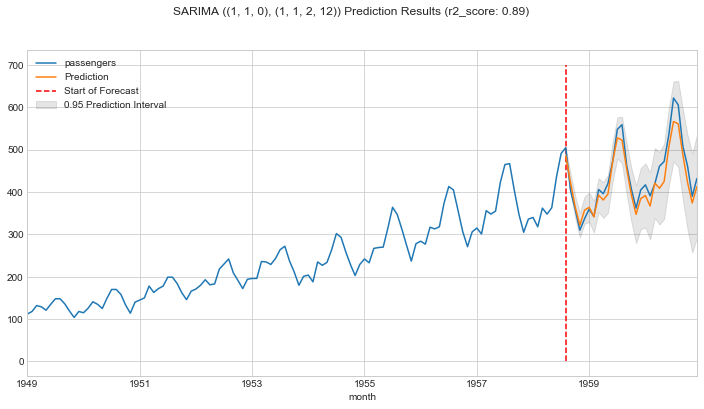

In [21]:
fig, ax = plt.subplots(figsize=(12,6))
data.plot(ax=ax);
ax.vlines('1958-08-01', 0, 700, linestyle='--', color='r', label='Start of Forecast')
ax.plot(predict_index, predicted_value, label='Prediction')
ax.fill_between(predict_index, predicted_lb, predicted_ub, color='k', alpha=0.1, label='0.95 Prediction Interval')
ax.legend(loc='upper left')
plt.suptitle(f'SARIMA {optimal[0][0]} Prediction Results (r2_score: {round(r2,2)})')
plt.show()

r^2 값이 많이 개선이 되었다.

### 3.4 3 Diagonisis Check - auto_arima

###### auto_arima라는 package 도 있다

In [22]:
# Parameter search

auto_arima_model = auto_arima(train_data, start_p=1, start_q=1, max_p=3, max_q=3, m=12, seasonal=True,
                              d=1, D=1,
                             max_P=3, max_Q=3,
                             trace=True,
                             error_action='ignore',
                             suppress_warnings=True,
                             stepwise=False)

# start pq / max pq / seasonal 다 지정 가능 / error 무시기능 까지 있음 / Trace는 결과값을 보여준다.
# 학습이 끝나면 바로 최적의 값으로 세팅이 된다. 엄청 편리한 패키지다.

 ARIMA(0,1,0)(0,1,0)[12]             : AIC=757.826, Time=0.01 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=756.988, Time=0.07 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=758.826, Time=0.36 sec
 ARIMA(0,1,0)(0,1,3)[12]             : AIC=758.186, Time=0.60 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=756.959, Time=0.07 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=758.922, Time=0.17 sec
 ARIMA(0,1,0)(1,1,2)[12]             : AIC=inf, Time=1.07 sec
 ARIMA(0,1,0)(1,1,3)[12]             : AIC=754.685, Time=1.84 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=758.869, Time=0.13 sec
 ARIMA(0,1,0)(2,1,1)[12]             : AIC=760.726, Time=0.54 sec
 ARIMA(0,1,0)(2,1,2)[12]             : AIC=inf, Time=1.32 sec
 ARIMA(0,1,0)(2,1,3)[12]             : AIC=756.686, Time=2.35 sec
 ARIMA(0,1,0)(3,1,0)[12]             : AIC=759.643, Time=0.42 sec
 ARIMA(0,1,0)(3,1,1)[12]             : AIC=inf, Time=2.89 sec
 ARIMA(0,1,0)(3,1,2)[12]             : AIC=756.688, Time=3.52 sec
 ARIMA(0,1,1)(0,1,0)[1

In [23]:
auto_arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                         SARIMAX Results                                          
==================================================================================================
Dep. Variable:                                          y   No. Observations:                  115
Model:             SARIMAX(1, 1, 0)x(1, 1, [1, 2, 3], 12)   Log Likelihood                -370.278
Date:                                    Thu, 21 Oct 2021   AIC                            752.557
Time:                                            21:03:05   BIC                            768.307
Sample:                                                 0   HQIC                           758.934
                                                    - 115                                         
Covariance Type:                                      opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2218      0.093     -2.388      0.017      -0.404      -0.040
ar.S.L12       0.9288      0.275      3.374      0.001       0.389       1.468
ma.S.L12      -1.2065      0.448     -2.692      0.007      -2.085      -0.328
ma.S.L24       0.2771      0.174      1.596      0.111      -0.063       0.618
ma.S.L36       0.1251      0.164      0.765      0.444      -0.195       0.446
sigma2        75.0386     19.073      3.934      0.000      37.656     112.421
===================================================================================
Ljung-Box (Q):                       40.92   Jarque-Bera (JB):                 2.50
Prob(Q):                              0.43   Prob(JB):                         0.29
Heteroskedasticity (H):               1.05   Skew:                             0.37
Prob(H) (two-sided):                  0.90   Kurtosis:                         2.81
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### 3.5 3 use Model to Forecast - auto_arima

In [24]:
prediction = auto_arima_model.predict(len(test_data), return_conf_int=True)
predicted_value = prediction[0]
predicted_ub = prediction[1][:,0]
predicted_lb = prediction[1][:,1]
predict_index = list(test_data.index)
r2 = r2_score(test_data, predicted_value)

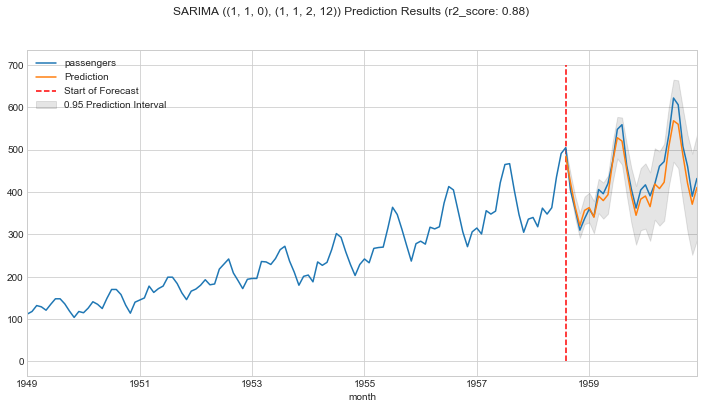

In [25]:
fig, ax = plt.subplots(figsize=(12,6))
data.plot(ax=ax);
ax.vlines('1958-08-01', 0, 700, linestyle='--', color='r', label='Start of Forecast')
ax.plot(predict_index, predicted_value, label='Prediction')
ax.fill_between(predict_index, predicted_lb, predicted_ub, color='k', alpha=0.1, label='0.95 Prediction Interval')
ax.legend(loc='upper left')
plt.suptitle(f'SARIMA {optimal[0][0]} Prediction Results (r2_score: {round(r2,2)})')
plt.show()

## 4. Case Study : 주가예측

활용 데이터2 : 실제 주가 예측
* 상장 법인 목록에서 종목코드를 통해 기업 주가 다운로드
* 최근 5년간 주식 관련 정보에 대한 시계열 데이터
* 데이터 구조 :[1219 * 6]

In [26]:
# 기업명을 넣었을 때 코드가 반환된다
def get_code(df, name):
    code = df.query("name=='{}'".format(name))['code'].to_string(index=False)
    code = code.strip()
    return code

In [27]:
code_data = pd.read_html('http://kind.krx.co.kr/corpgeneral/corpList.do?method=download&searchType=13', header=0)[0]
code_data # 2467 rows * 9 columns

,회사명,종목코드,업종,주요제품,상장일,결산월,대표자명,홈페이지,지역
0,DRB동일,4840,고무제품 제조업,"고무벨트(V벨트,콘베이어벨트,평벨트),프라스틱제품 제조,판매",1976-05-21,12월,류영식,http://drbworld.com,부산광역시
1,DSR,155660,1차 비철금속 제조업,합섬섬유로프,2013-05-15,12월,홍석빈,http://www.dsr.com,부산광역시
2,GS,78930,기타 금융업,지주회사/부동산 임대,2004-08-05,12월,"허태수, 홍순기 (각자 대표이사)",NaN,서울특별시
3,GS글로벌,1250,상품 종합 도매업,"수출입업(시멘트,철강금속,전기전자,섬유,기계화학),상품중개,광업,채석업/하수처리 서...",1976-06-26,12월,김태형,http://www.gsgcorp.com,서울특별시
4,HDC현대산업개발,294870,건물 건설업,"외주주택, 자체공사, 일반건축, 토목 등",2018-06-12,12월,"권순호, 정경구",http://www.hdc-dvp.com,서울특별시
...,...,...,...,...,...,...,...,...,...
2462,토마토시스템,393210,소프트웨어 개발 및 공급업,UI솔루션,2021-10-14,12월,이상돈,http://www.tomatosystem.co.kr/,서울특별시
2463,툴젠,199800,자연과학 및 공학 연구개발업,"유전자가위 (유전체 교정 도구) 및 이를 이용한 유전자세포치료제, 고부가가치 가축,...",2014-06-25,12월,"김영호, 이병화(각자 대표이사)",http://www.toolgen.com,서울특별시
2464,플럼라인생명과학,222670,자연과학 및 공학 연구개발업,"강아지암치료제,돼지DNA테라피",2015-07-28,12월,김앤토니경태,http://www.plsdna.com,서울특별시
2465,한국미라클피플사,331660,기타 화학제품 제조업,"은나노스텝, 닥터오렌지 등",2019-10-28,12월,이호경,http://www.kmpc.co.kr,경기도


In [28]:
code_data = code_data[['회사명', '종목코드']]
code_data = code_data.rename(columns={'회사명':'name', '종목코드':'code'})
code_data.code = code_data.code.map('{:06d}'.format)